# Example 2 - Custom Approach

This notebook demonstrates how to use the TX2 dashboard with a sequence classification transformer using the custom approach as described in the "Basic Usage" docs. To demonstrate, we simply take the default functions for each and manually define them.

In [1]:
%cd -q ..
%load_ext autoreload
%autoreload 2
%matplotlib inline

We enable logging to view the output from `wrapper.prepare()` further down in the notebook. (It's a long running function, and logs which step it's on.)

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import numpy as np
import pandas as pd
import torch
from torch import cuda
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer, BertTokenizer

In this example notebook, we use the 20 newsgroups dataset, which can be downloaded through huggingface via below:

In [4]:
from datasets import load_dataset

# getting newsgroups data from huggingface
train_data = pd.DataFrame(data=load_dataset("SetFit/20_newsgroups", split="train"))
test_data = pd.DataFrame(data=load_dataset("SetFit/20_newsgroups", split="test"))

# setting up pytorch device
if cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"

device

Using custom data configuration SetFit--20_newsgroups-f9362e018b6adf67
Reusing dataset json (/home/81n/.cache/huggingface/datasets/SetFit___json/SetFit--20_newsgroups-f9362e018b6adf67/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
Using custom data configuration SetFit--20_newsgroups-f9362e018b6adf67
Reusing dataset json (/home/81n/.cache/huggingface/datasets/SetFit___json/SetFit--20_newsgroups-f9362e018b6adf67/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


'cuda'

Defined below is a simple sequence classification model with a variable for the language model itself `l1`. Since it is a BERT model, we take the sequence embedding from the `[CLS]` token (via `output_1[0][:, 0, :])`) and pipe that into the linear layer.

In [5]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained("bert-base-cased")
        self.l2 = torch.nn.Linear(768, 20)

    def forward(self, ids, mask):
        output_1 = self.l1(ids, mask)
        output = self.l2(output_1[0][:, 0, :])  # use just the [CLS] output embedding
        return output


model = BERTClass()
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some simplistic data cleaning, and putting all data into dataframes for the wrapper

In [6]:
def clean_text(text):
    text = str(text)
    # text = text[text.index("\n\n") + 2 :]
    text = text.replace("\n", " ")
    text = text.replace("    ", " ")
    text = text.replace("   ", " ")
    text = text.replace("  ", " ")
    text = text.strip()
    return text

In [7]:
# clean long white space or extensive character returns
train_data.text = train_data.text.apply(lambda x: clean_text(x))
test_data.text = test_data.text.apply(lambda x: clean_text(x))

# remove empty entries or trivially short ones
train_cleaned = train_data[train_data["text"].str.len() > 1]
test_cleaned = test_data[test_data["text"].str.len() > 1]
train_cleaned

,text,label,label_text
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,Do you have Weitek's address/phone number? I'd...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space
...,...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye) DN...,13,sci.med
11310,"I have a (very old) Mac 512k and a Mac Plus, b...",4,comp.sys.mac.hardware
11311,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware
11312,Wouldn't this require a hyper-sphere. In 3-spa...,1,comp.graphics


## Training

This section minimally trains the classification and language model - nothing fancy here, just to give the dashboard demo something to work with. Most of this is similar to the huggingface tutorial notebooks.

In [8]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-05)

In [9]:
class EncodedSet(Dataset):
    def __init__(self, dataframe: pd.DataFrame, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        print(self.len)

    def __getitem__(self, index):
        text = str(self.data.text[index])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_token_type_ids=True,
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.data.label[index], dtype=torch.long),
        }

    def __len__(self):
        return self.len


train_cleaned.reset_index(drop=True, inplace=True)
test_cleaned.reset_index(drop=True, inplace=True)

train_set = EncodedSet(train_cleaned, tokenizer, 256)
test_set = EncodedSet(test_cleaned[:1000], tokenizer, 256)

train_params = {"batch_size": 16, "shuffle": True, "num_workers": 0}

test_params = {"batch_size": 2, "shuffle": True, "num_workers": 0}

# put everything into data loaders
train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

11014
1000


In [10]:
def train(epoch):
    model.train()

    loss_history = []
    for _, data in tqdm(
        enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
    ):
        ids = data["ids"].to(device, dtype=torch.long)
        mask = data["mask"].to(device, dtype=torch.long)
        targets = data["targets"].to(device, dtype=torch.long)

        outputs = model(ids, mask).squeeze()

        optimizer.zero_grad()
        loss = loss_function(outputs, targets)
        if _ % 100 == 0:
            print(f"Epoch: {epoch}, Loss:  {loss.item()}")
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #         torch.cuda.empty_cache()
    return loss_history

In [11]:
losses = []
for epoch in range(1):
    losses.extend(train(epoch))

Epoch 0:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch: 0, Loss:  3.0857298374176025
Epoch: 0, Loss:  1.8240100145339966
Epoch: 0, Loss:  1.2589420080184937
Epoch: 0, Loss:  1.3561142683029175
Epoch: 0, Loss:  1.4881296157836914
Epoch: 0, Loss:  0.8317107558250427
Epoch: 0, Loss:  1.1163581609725952


The wrapper uses an `encodings` dictionary for various labels/visualizations, and can be set up with something similar to:

In [12]:
encodings = (
    train_cleaned[["label", "label_text"]]
    .groupby(["label_text"])
    .apply(lambda x: x["label"].tolist()[0])
    .to_dict()
)
encodings

{'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}

## TX2

This section shows how to put everything into the TX2 wrapper to get the dashboard widget displayed.

In [13]:
from tx2.dashboard import Dashboard
from tx2.wrapper import Wrapper

In [14]:
from tx2 import utils

def custom_encoding_function(text):
    encoded = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=256,
        padding="max_length",
        truncation=True,
        return_token_type_ids=True,
    )
    return {
        "input_ids": torch.tensor(encoded["input_ids"], device=device),
        "attention_mask": torch.tensor(encoded["attention_mask"], device=device),
    }


def custom_classification_function(inputs):
    return torch.argmax(model(inputs["input_ids"], inputs["attention_mask"]), dim=1)


def custom_embedding_function(inputs):
    return model.l1(inputs["input_ids"], inputs["attention_mask"])[0][
        :, 0, :
    ]  # [CLS] token embedding


def custom_soft_classification_function(inputs):
    return model(inputs["input_ids"], inputs["attention_mask"])

In [15]:
wrapper = Wrapper(
    train_texts=train_cleaned.text,
    train_labels=train_cleaned.label,
    test_texts=test_cleaned.text[:2000],
    test_labels=test_cleaned.label[:2000],
    encodings=encodings,
    cache_path="data/custom_cache",
    overwrite=True,
)
wrapper.encode_function = custom_encoding_function
wrapper.classification_function = custom_classification_function
wrapper.soft_classification_function = custom_soft_classification_function
wrapper.embedding_function = custom_embedding_function
wrapper.prepare()

INFO:root:Cache path found
INFO:root:Checking for cached predictions...
INFO:root:Running classifier...
INFO:root:Saving predictions...
INFO:root:Writing to data/custom_cache/predictions.json
INFO:root:Done!
INFO:root:Checking for cached embeddings...
INFO:root:Embedding training and testing datasets
INFO:root:Saving embeddings...
INFO:root:Writing to data/custom_cache/embedding_training.json
INFO:root:Writing to data/custom_cache/embedding_testing.json
INFO:root:Done!
INFO:root:Checking for cached projections...
INFO:root:Training projector...
INFO:root:Applying projector to test dataset...
INFO:root:Saving projections...
INFO:root:Writing to data/custom_cache/projections_training.json
INFO:root:Writing to data/custom_cache/projections_testing.json
INFO:root:Writing to data/custom_cache/projector.pkl.gz
INFO:root:Done!
INFO:root:Checking for cached salience maps...
INFO:root:Computing salience maps...


  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Saving salience maps...
INFO:root:Writing to data/custom_cache/salience.pkl.gz
INFO:root:Done!
INFO:root:Checking for cached cluster profiles...
INFO:root:Clustering projections...
INFO:root:Saving cluster profiles...
INFO:root:Writing to data/custom_cache/clusters.json
INFO:root:Writing to data/custom_cache/cluster_profiles.pkl.gz
INFO:root:Done!
INFO:root:Saving cluster labels...
INFO:root:Writing to data/custom_cache/cluster_labels.json
INFO:root:Done!
INFO:root:Saving cluster word counts...
INFO:root:Writing to data/custom_cache/cluster_words.json
INFO:root:Writing to data/custom_cache/cluster_class_words.json
INFO:root:Done!


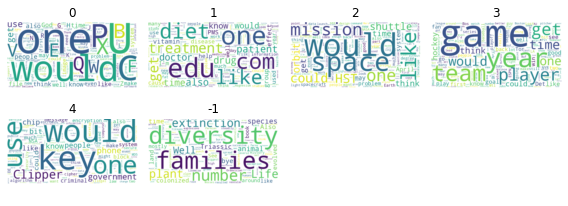

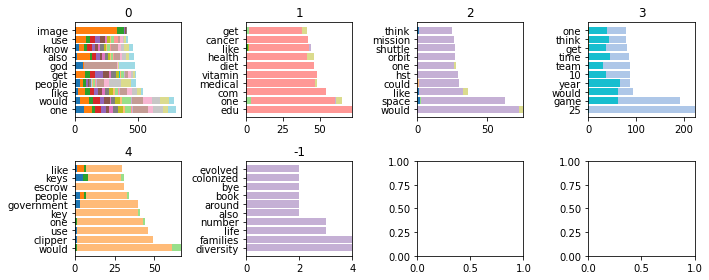

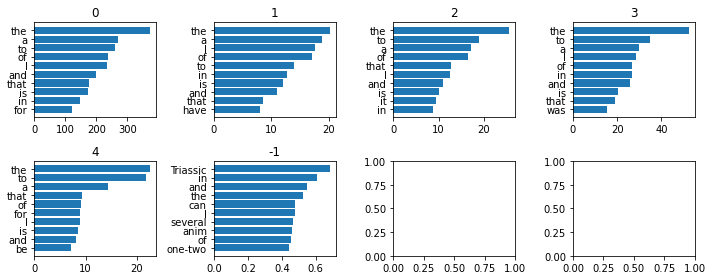

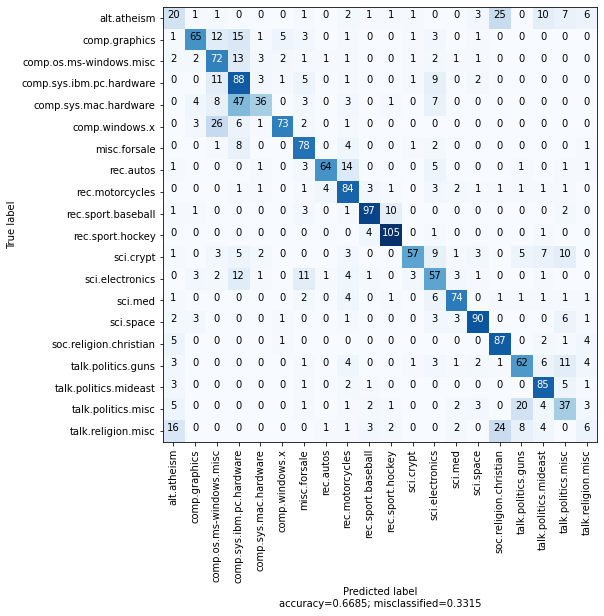

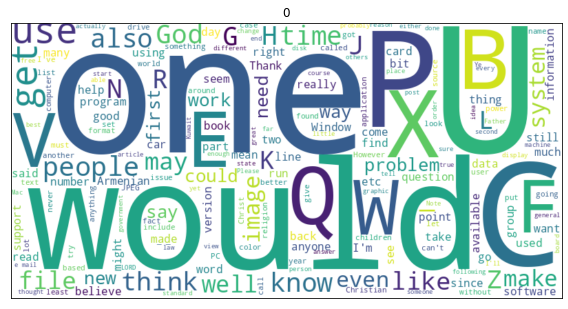

In [16]:
dash = Dashboard(wrapper, show_wordclouds=True)
dash.render()

To play with different UMAP and DBSCAN arguments without having to recompute the entire `prepare()` function, you can use `recompute_projections` (which will recompute both the projections and visual clusterings) or `recompute_visual_clusterings` (which will only redo the clustering)

In [17]:
# wrapper.recompute_visual_clusterings(dbscan_args=dict())
# wrapper.recompute_projections(umap_args=dict(min_dist=.2), dbscan_args=dict())

To test or debug the classification model/see what raw outputs the viusualizations are getting, or create your own visualization tools, you can manually call the `classify()`, `soft_classify()`, `embed()` functions, or get access to any of the cached data as seen in the bottom cell

In [18]:
wrapper.classify(["testing"])

[6]

In [19]:
wrapper.soft_classify(["testing"])

[[-0.276504784822464,
  0.0480557419359684,
  -0.06954710930585861,
  -0.6020134687423706,
  0.23548676073551178,
  -0.5968973636627197,
  0.7885699272155762,
  0.8527497053146362,
  1.7247512340545654,
  0.5918079614639282,
  0.981977105140686,
  -1.0134834051132202,
  0.5268479585647583,
  -0.8338075876235962,
  0.36251699924468994,
  -0.3439621925354004,
  -0.4577031433582306,
  -0.8680683970451355,
  0.17231078445911407,
  -0.32367798686027527]]

In [20]:
wrapper.embed(["testing"])

[[-0.7674786448478699,
  0.2836921513080597,
  1.2392399311065674,
  0.29533854126930237,
  -0.40918615460395813,
  0.15367698669433594,
  -0.0054212226532399654,
  -0.06325314939022064,
  -0.4904989004135132,
  -0.7218189239501953,
  -0.12856526672840118,
  -0.2915543019771576,
  0.12261268496513367,
  1.3576784133911133,
  -0.5804318785667419,
  -0.17411932349205017,
  0.8554975390434265,
  0.19367028772830963,
  0.7872521281242371,
  -0.2836591303348541,
  0.0083768917247653,
  -0.5186717510223389,
  0.7158846259117126,
  -0.7153240442276001,
  -0.045054733753204346,
  -0.8384860754013062,
  0.689354419708252,
  0.06915898621082306,
  0.2349252998828888,
  0.03410595655441284,
  0.1750923991203308,
  0.5857744812965393,
  -0.4248504638671875,
  0.7399815917015076,
  0.4002230167388916,
  0.20601731538772583,
  0.006338462233543396,
  0.16501688957214355,
  -0.36674731969833374,
  0.832068681716919,
  0.41971495747566223,
  0.11280800402164459,
  0.09413046389818192,
  0.258495450019

In [21]:
# cached data:
# wrapper.embeddings_training
# wrapper.embeddings_testing
# wrapper.projector
# wrapper.projections_training
# wrapper.projections_testing
# wrapper.salience_maps
# wrapper.clusters
# wrapper.cluster_profiles
# wrapper.cluster_words_freqs
# wrapper.cluster_class_word_sets